In [1]:
import sunpy
import sunpy.map
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import ImageNormalize, AsinhStretch, SqrtStretch
import matplotlib.pyplot as plt
from sunkit_image import coalignment
from sun_blinker import SunBlinker
from sunpy.coordinates import propagate_with_solar_surface

In [2]:
aia_335_map = sunpy.map.Map('../../src/AIA/20221024/335/lvl15/aia.lev1_euv_12s.2022-10-24T190027Z.335.image.fits')
aia_335_map_crop = aia_335_map.submap(SkyCoord(-700*u.arcsec,-100*u.arcsec, frame=aia_335_map.coordinate_frame),
                                      top_right = SkyCoord(-100*u.arcsec,500*u.arcsec, frame=aia_335_map.coordinate_frame))

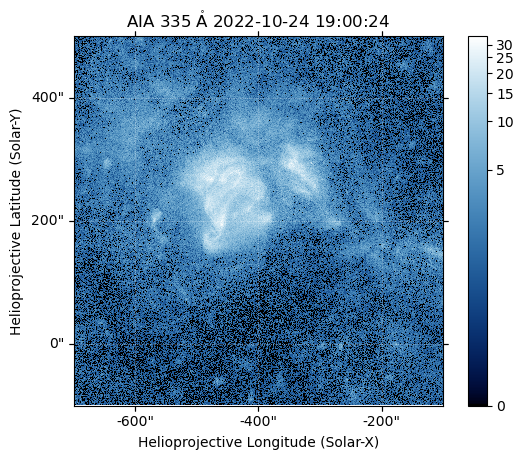

In [3]:
aia_335_map_crop.plot(vmin=0)
plt.colorbar()

In [4]:
xrt_map = sunpy.map.Map('../../src/XRT/20221024/l1_deconv/L1_XRT20221024_190036.2.fits')
xrt_map.meta['rsun_ref'] = aia_335_map.meta['rsun_ref']

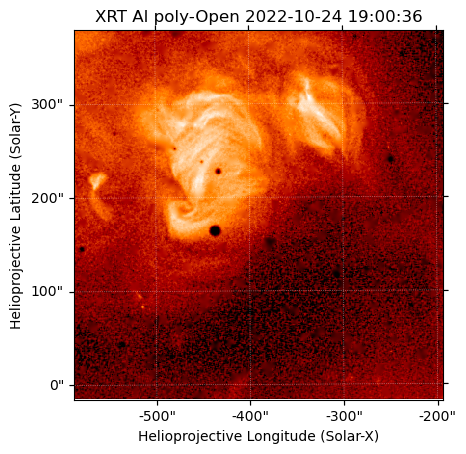

In [5]:
xrt_map.plot()

In [6]:
def coalign_shift(big_map, small_map):
    yshift, xshift = coalignment._calculate_shift(big_map.data, small_map.data)
    reference_coord = big_map.pixel_to_world(xshift, yshift)
    Txshift = reference_coord.Tx - small_map.bottom_left_coord.Tx
    Tyshift = reference_coord.Ty - small_map.bottom_left_coord.Ty

    return Txshift, Tyshift
    

In [7]:
aia_335_resample_nx = (aia_335_map_crop.scale.axis1 * aia_335_map_crop.dimensions.x)/xrt_map.scale.axis1.to(u.arcsec/u.pix)
aia_335_resample_ny = (aia_335_map_crop.scale.axis2 * aia_335_map_crop.dimensions.y)/xrt_map.scale.axis2.to(u.arcsec/u.pix)
aia_335_map_crop_resample = aia_335_map_crop.resample(u.Quantity((aia_335_resample_nx, aia_335_resample_ny)))

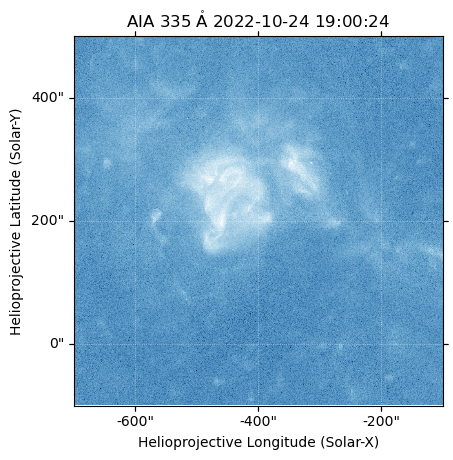

In [8]:
aia_335_map_crop_resample.plot()

In [9]:
Txshift_xrt_to_aia, Tyshift_xrt_to_aia = coalign_shift(aia_335_map_crop_resample, xrt_map)

In [10]:
Txshift_xrt_to_aia, Tyshift_xrt_to_aia

(<Angle -3.77594416 arcsec>, <Angle -11.05682996 arcsec>)

In [11]:
xrt_map_shifted = xrt_map.shift_reference_coord(Txshift_xrt_to_aia, Tyshift_xrt_to_aia)

In [12]:
SunBlinker(xrt_map, aia_335_map_crop_resample, reproject=True)

In [13]:
SunBlinker(xrt_map_shifted, aia_335_map_crop_resample, reproject=True)

In [14]:
eis_195_velmap_shift = sunpy.map.Map("../../src/EIS/DHB_007_v2/20221025T0023/sunpymaps/eis_195_velmap_shift.fits")
with propagate_with_solar_surface(rotation_model='rigid'):
    eis_195_velmap_derot = eis_195_velmap_shift.reproject_to(xrt_map_shifted.wcs)

For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crlt_obs,crln_obs
 [sunpy.map.mapbase]


In [15]:
xrt_colormap = plt.get_cmap('hinodexrt')

(-0.5, 383.5, -0.5, 383.5)

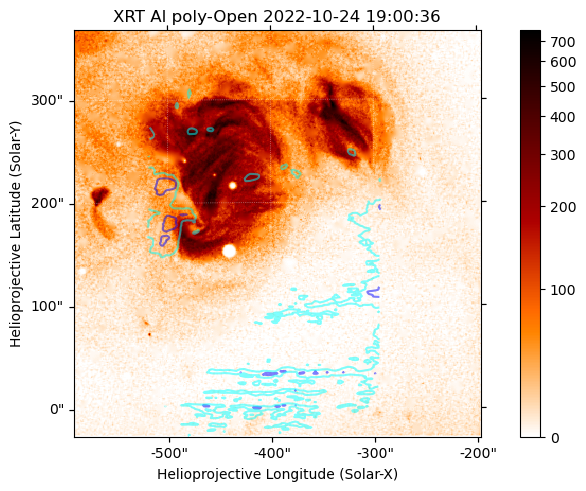

In [16]:
fig = plt.figure(layout='constrained')
ax = fig.add_subplot(projection=xrt_map_shifted.wcs)

xrt_map_shifted.plot(axes=ax,cmap=xrt_colormap.reversed(), norm=ImageNormalize(stretch=AsinhStretch()))
plt.colorbar()

bounds = ax.axis()
with propagate_with_solar_surface(rotation_model='rigid'):
    eis_195_velmap_derot.draw_contours([-10,-5],colors=["blue","cyan"], axes=ax, alpha=0.5)
# ax.set_xlim(0,150)
# ax.set_ylim(150,350)
ax.axis(bounds)


